In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from transformers import *
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
import torch
from transformers.data.processors.utils import InputExample
from torch import nn
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader
from torch.optim import Adam
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm, tnrange 
import time 

In [3]:
reader = pd.read_json('data/yelp_dataset/yelp_academic_dataset_review.json', lines=True, chunksize=10000)

In [4]:
def generate_dataset(json_reader, nrows=10000, min_length=100, max_length = 128):
    df = None
    while True:
        df_candidate = next(json_reader)
        df_candidate = df_candidate.loc[(df_candidate['text'].str.len() > min_length) & (df_candidate['text'].str.len() <= max_length), ['text', 'stars']]
        if df is None:
            df = df_candidate
        else:
            df = df.append(df_candidate)
        for rating in range(1, 6, 1):
            df_rating = df[df['stars'] == rating]
            if len(df_rating) > nrows//5:
                df_rating = df_rating.iloc[:nrows//5, :]
                df = df.loc[~(df['stars'] == rating), :]
                df = df.append(df_rating)
        if len(df) == nrows:
            return df

In [5]:
train_df = generate_dataset(reader)
test_df = generate_dataset(reader)

In [6]:
train_df['stars'].value_counts()


5    2000
4    2000
3    2000
2    2000
1    2000
Name: stars, dtype: int64

In [7]:
test_df['stars'].value_counts()


5    2000
4    2000
3    2000
2    2000
1    2000
Name: stars, dtype: int64

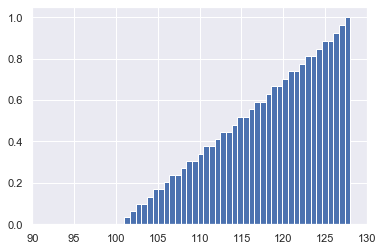

In [8]:
kwargs = {'cumulative': True}
plt.hist(train_df['text'].str.len().tolist() + test_df['text'].str.len().tolist(),cumulative=True, density=True, bins=40)
plt.xlim(left=90, right=130) 
plt.show()

In [9]:
train_df.head()


,text,stars
16,10pm on a super bowl Sunday and they're alread...,1
929,If you like the way cake mix from a box tastes...,1
1181,Not worth it. My friend and I both felt sick a...,1
1458,"No customer service as the ""help"" wander aroun...",1
1493,"Worst place I've ever been , they don't care a...",1


In [10]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [11]:
hidden_size = 200

In [12]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
model = BertForSequenceClassification.from_pretrained('bert-base-cased', num_labels=hidden_size)
model.classifier.add_module('bert_activation', nn.Tanh())
model.classifier.add_module('prediction', nn.Linear(hidden_size, 5))

FINE_TUNE = True
print(f'Total model trainable parameters {count_parameters(model)}')
if FINE_TUNE:
    for param in model.bert.parameters():
        param.requires_grad = False

    for param in model.classifier.parameters():
        param.requires_grad = True
    print(f'Total head trainable parameters {count_parameters(model)}')
model.cuda();

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

Total model trainable parameters 108465077
Total head trainable parameters 154805


AssertionError: Torch not compiled with CUDA enabled

In [13]:
model.classifier

Linear(
  in_features=768, out_features=200, bias=True
  (bert_activation): Tanh()
  (prediction): Linear(in_features=200, out_features=5, bias=True)
)

In [14]:
tokenized = tokenizer.tokenize(' I am parachuting with you')
print(tokenized)
print(tokenizer.encode(tokenized, add_special_tokens=False))
print(tokenizer.encode(tokenized, add_special_tokens=True))

['I', 'am', 'para', '##chu', '##ting', 'with', 'you']
[146, 1821, 18311, 17143, 1916, 1114, 1128]
[101, 146, 1821, 18311, 17143, 1916, 1114, 1128, 102]


In [15]:
# https://huggingface.co/transformers/main_classes/processors.html
def get_features(df, text_col, label_col):
    l = [InputExample(guid=idx, text_a=df.loc[idx, text_col], label=df.loc[idx, label_col]) for 
       idx, row in tqdm(df.iterrows(), total=df.shape[0])]
    features = glue_convert_examples_to_features(examples=l, 
                                    tokenizer=tokenizer,
                                    max_length=300,
                                    label_list = df[label_col].values,
                                    output_mode='regression')

    all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
    all_attention_mask = torch.tensor([f.attention_mask for f in features], dtype=torch.long)
    all_token_type_ids = torch.tensor([f.token_type_ids for f in features], dtype=torch.long)
    all_labels = torch.tensor([f.label-1 for f in features], dtype=torch.long)
    dataset = TensorDataset(all_input_ids, all_attention_mask, all_labels)
    return dataset

In [16]:
train_dataset = get_features(train_df, 'text', 'stars')
test_dataset = get_features(test_df, 'text', 'stars')

/Users/saehuh/opt/anaconda3/lib/python3.7/site-packages/transformers/data/processors/glue.py:67: FutureWarning: This function will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/master/examples/text-classification/run_glue.py
  warnings.warn(DEPRECATION_WARNING.format("function"), FutureWarning)


In [17]:
val_idx, train_idx = train_test_split(np.arange(len(train_dataset)), random_state=4, train_size=0.1)
total_size = len(train_dataset)
val_dataset = TensorDataset(*train_dataset[val_idx])
train_dataset = TensorDataset(*train_dataset[train_idx])
assert total_size == len(val_dataset) + len(train_dataset)

In [18]:
# works
model(input_ids=train_dataset[:2][0].cuda(), 
      attention_mask=train_dataset[:2][1].cuda(), 
      labels=train_dataset[:2][2].cuda());

AssertionError: Torch not compiled with CUDA enabled

In [19]:
batch_size = 16
gradient_every = 32
assert batch_size <= gradient_every and gradient_every % batch_size == 0

accumulation_steps = gradient_every//batch_size

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size*2, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size*2, shuffle=False)

epochs = 25

lr = 0.002
optimizer = AdamW(model.classifier.parameters(), lr=lr)  

In [20]:
tr_losses = []
v_losses = []

In [21]:
# scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=len(train_data_loader)*epochs)
for epoch in tnrange(epochs, desc='epoch'):
    """ Training stage """
    epoch_tr_losses = []
    print(f'epoch {epoch+1}')
    for k, (input_ids, attention_mask, labels) in enumerate(tqdm(train_dataloader, total=len(train_dataloader), desc='batch')):
        feed_dict = {'input_ids': input_ids.cuda(),
                     'attention_mask': attention_mask.cuda(),
                     'labels': labels.cuda()}
        
        loss, _ = model(**feed_dict)

        # gradient accumulation
        epoch_tr_losses.append(loss.item())
        loss = loss/accumulation_steps
        loss.backward()
        if (k + 1) % accumulation_steps == 0:
            optimizer.step()
            model.zero_grad()

    tr_losses.append(np.mean(epoch_tr_losses))
    print(f'train NLL loss: {np.mean(epoch_tr_losses)}')
  
    """ Validation stage """
    epoch_v_losses = [] 
    with torch.no_grad():
        for k, (input_ids, attention_mask, labels) in enumerate(tqdm(val_dataloader, total=len(val_dataloader), desc='val batch')):
            feed_dict = {'input_ids': input_ids.cuda(),
                         'attention_mask': attention_mask.cuda(),
                         'labels': labels.cuda()} 

            loss, pred = model(**feed_dict)
            epoch_v_losses.append(loss.item())
        v_losses.append(np.mean(epoch_v_losses))
    print(f'validation BCE loss: {np.mean(epoch_v_losses)}')
    torch.save(model.classifier.state_dict(), f'/kaggle/working/yelp-head{epoch}.pt')

epoch 1


AssertionError: Torch not compiled with CUDA enabled

In [22]:
batch_predictions, batch_actual = [], []
with torch.no_grad():
    for k, (input_ids, attention_mask, labels) in enumerate(tqdm(test_dataloader, total=len(test_dataloader), desc='val batch')):
        feed_dict = {'input_ids': input_ids.cuda(),
                     'attention_mask': attention_mask.cuda()} 
        
        pred = model(**feed_dict)[0].cpu()
        batch_predictions.append(pred.numpy())
        batch_actual.append(labels)

AssertionError: Torch not compiled with CUDA enabled

In [23]:
predictions = np.array([i for k in batch_predictions for i in k ])

predictions = np.argmax(predictions, axis=1)
actual = np.array([i for k in batch_actual for i in k ])

AxisError: axis 1 is out of bounds for array of dimension 1

In [24]:
from sklearn.metrics import f1_score
f1_score(actual, predictions, average='micro')

NameError: name 'actual' is not defined

In [25]:
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')

SyntaxError: invalid syntax (<ipython-input-25-754f0b4f9dc4>, line 3)

In [26]:
# compute the confusion matrix
from sklearn.metrics import confusion_matrix
import itertools
confusion_mtx = confusion_matrix(actual, predictions) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(1,6))
plt.show()

NameError: name 'actual' is not defined